In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

---

# Load datasets

In [3]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

dataset = [train, test]

### Understand the loaded data and think about how to do feature engineering or data cleansing.

In [4]:
train.shape, test.shape

((891, 12), (418, 11))

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


1. Need to extract information as categorical variables.
2. Convert to a numerical value.
3. Remove the missing value.

In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### There are 177 missing values ​​in Age, 687 missing values ​​in Cabin, and 2 missing values ​​in Embarked.

In [7]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### There are 86 missing values in Age, 1 missing value in Fare, and 327 missing values in Cabin

---

# Visualization

In [8]:
def visualization(feature):
    O = train[train['Survived'] == 1][feature].value_counts()
    X = train[train['Survived'] == 0][feature].value_counts()
    visual_df = pd.DataFrame([O, X])
    visual_df.index = ['Survived', 'Dead']
    visual_df.plot(kind = 'bar', stacked=True, figsize=(12, 5), title=feature)

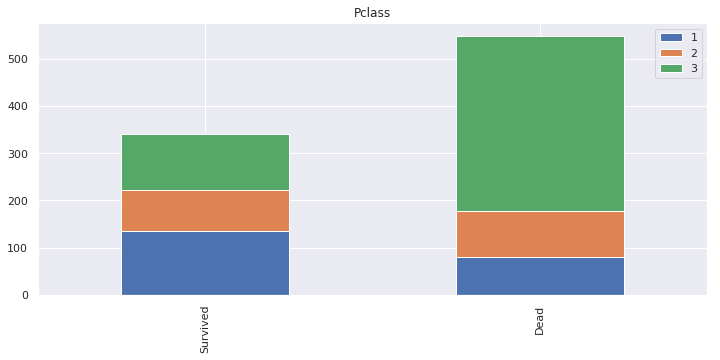

In [9]:
visualization('Pclass')

#### If Pclass is 1, likely to survive, and if it is 3, likely to die.

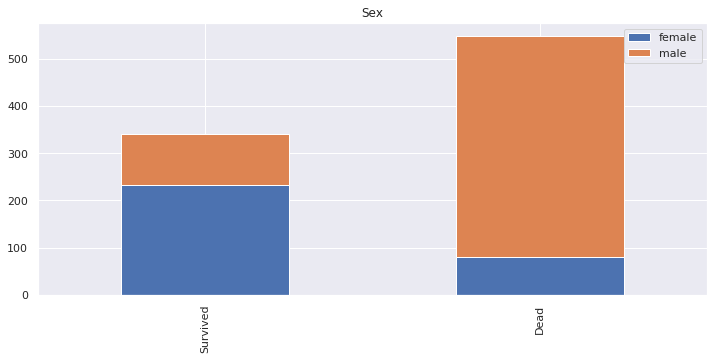

In [10]:
visualization('Sex')

#### If Sex is female, likely to survive, and if it is male, likely to die.

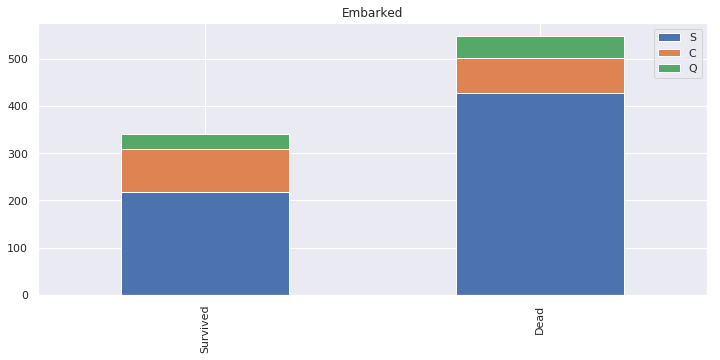

In [11]:
visualization('Embarked')

#### If Embarked is S, likely to die, if it is C, likely to survive, and if it is Q, likely to die.

---

# Feature Engineering

#### Merge SibSP and Parch, add 1, and create a new feature called Family.

In [12]:
for vector in dataset:
    vector['Family'] = vector['SibSp'] + vector['Parch'] + 1

train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


#### Create a feature called Alone to check if boarding with  family affects survival.

In [13]:
for vector in dataset:
    vector['Alone'] = 0 # boarded with family
    vector.loc[vector['Family'] == 1, 'Alone'] = 1 # boarded alone

train[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()

,Alone,Survived
0,0,0.505650
1,1,0.303538


#### Boarded alone shows a survival rate of 50% and boarded with a family shows a survival rate of 30%.

#### SibSP, Parch, and Family features used to create the Alone feature are now unnecessary, so delete them.

In [14]:
train = train.drop(['SibSp', 'Parch', 'Family'], axis=1)
test = test.drop(['SibSp', 'Parch', 'Family'], axis=1)

#### Replace 2 missing values ​​of Embarked with S, the largest amount of data.

In [15]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

#### Fare's missing values ​​are grouped into Pclass and replaced with the median of 1, 2, 3.

#### Visualize to see the distribution of the fare.

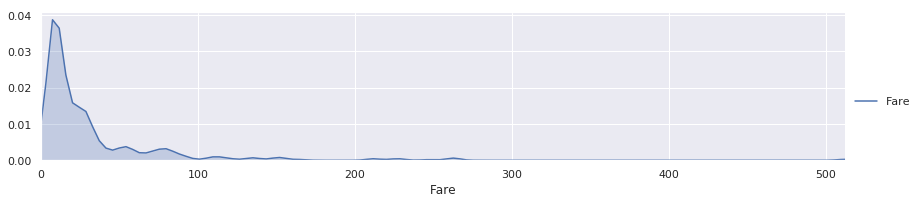

In [16]:
facet = sns.FacetGrid(train, aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim = (0, train['Fare'].max()))
facet.add_legend()

plt.show()

#### To utilize the Fare data, create 4 groups and put similar amounts of data in each group.

In [17]:
train['Fare_Division'] = pd.qcut(train['Fare'], 4)
test['Fare_Division'] = pd.qcut(test['Fare'],4 )

train[['Fare_Division', 'Survived']].groupby(['Fare_Division'], as_index=False).mean()

,Fare_Division,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


#### Extract Title data from Name data.

In [18]:
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract('([A-Za-z]+)\.', expand=False)

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

#### Create a group for each Title and replace Age's missing value with the average of the Title.

In [19]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Jonkheer      1
Sir           1
Lady          1
Ms            1
Capt          1
Don           1
Mme           1
Countess      1
Name: Title, dtype: int64

In [20]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dona        1
Dr          1
Name: Title, dtype: int64

In [21]:
train['Age'].fillna(train.groupby('Title')['Age'].transform('median'), inplace=True)
test['Age'].fillna(test.groupby('Title')['Age'].transform('median'), inplace=True)

In [22]:
train['Age'].isnull().sum(), test['Age'].isnull().sum()

(0, 1)

#### 1 missing value remains in test data.

In [23]:
test[test['Age'].isnull()]

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Alone,Fare_Division,Title
88,980,3,female,NaN,364856,7.75,NaN,Q,1,"(-0.001, 7.896]",Ms


#### Because only one data has Title MS in the test data, the missing value is not replaced.
#### The data is replaced with the average value of the train data.

In [24]:
train[train['Title'] == 'Ms']['Age'].value_counts()

28.0    1
Name: Age, dtype: int64

In [25]:
test.loc[test['Age'].isnull(), 'Age'] = 28

#### Visualize the distribution of age data and divide it into 5 groups.

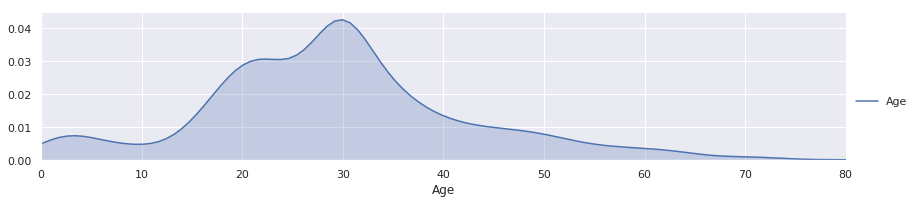

In [26]:
facet = sns.FacetGrid(train, aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim = (0, train['Age'].max()))
facet.add_legend()

plt.show()

In [27]:
train['Age_Division'] = pd.qcut(train['Age'], 5)
test['Age_Division'] = pd.qcut(test['Age'], 5)

train[['Age_Division', 'Survived']].groupby(['Age_Division'], as_index=False).mean()

,Age_Division,Survived
0,"(0.419, 20.0]",0.459016
1,"(20.0, 26.0]",0.397727
2,"(26.0, 30.0]",0.239234
3,"(30.0, 38.0]",0.496552
4,"(38.0, 80.0]",0.370787


#### Cabin data is excluded because the percentage of missing values is 77%.

---

# Data Cleansing

In [28]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Alone,Fare_Division,Title,Age_Division
0,1,0,3,male,22.0,A/5 21171,7.2500,NaN,S,0,"(-0.001, 7.91]",Mr,"(20.0, 26.0]"
1,2,1,1,female,38.0,PC 17599,71.2833,C85,C,0,"(31.0, 512.329]",Mrs,"(30.0, 38.0]"
2,3,1,3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,1,"(7.91, 14.454]",Miss,"(20.0, 26.0]"
3,4,1,1,female,35.0,113803,53.1000,C123,S,0,"(31.0, 512.329]",Mrs,"(30.0, 38.0]"
4,5,0,3,male,35.0,373450,8.0500,NaN,S,1,"(7.91, 14.454]",Mr,"(30.0, 38.0]"


In [29]:
sexMap = {'male':0, 'female':1}
train['Sex'] = train['Sex'].map(sexMap)
test['Sex'] = test['Sex'].map(sexMap)

In [30]:
embarkedMap = {'S':0, 'C':1, 'Q':2}
train['Embarked'] = train['Embarked'].map(embarkedMap)
test['Embarked'] = test['Embarked'].map(embarkedMap)

In [31]:
titleMap = {'Mr':0, 'Miss':1, 'Mrs':2, 'Marster':3, 'Dr':3, 'Rev':3, 'Mlle':3, 'Col':3, 'Major':3,
           'Ms':3, 'Lady':3, 'Jonkheer':3, 'Mme':3, 'Capt':3, 'Sir':3, 'Don':3, 'Countess':3}
train['Title'] = train['Title'].map(titleMap)
test['Title'] = test['Title'].map(titleMap)

In [32]:
train.loc[train['Fare'] <= 7.91, 'Fare'] = 0
train.loc[(7.91 < train['Fare']) & (train['Fare'] <= 14.454), 'Fare'] = 1
train.loc[(14.454 < train['Fare']) & (train['Fare'] <= 31), 'Fare'] = 2
train.loc[31 < train['Fare'], 'Fare'] = 3

test.loc[test['Fare'] <= 7.91, 'Fare'] = 0
test.loc[(7.91 < test['Fare']) & (test['Fare'] <= 14.454), 'Fare'] = 1
test.loc[(14.454 < test['Fare']) & (test['Fare'] <= 31), 'Fare'] = 2
test.loc[31 < test['Fare'], 'Fare'] = 3

In [33]:
train.loc[train['Age'] <= 20, 'Age'] = 0
train.loc[(20 < train['Age']) & (train['Age'] <= 26), 'Age'] = 1
train.loc[(26 < train['Age']) & (train['Age'] <= 30), 'Age'] = 2
train.loc[(30 < train['Age']) & (train['Age'] <= 38), 'Age'] = 3
train.loc[38 < train['Age'], 'Age'] = 4

test.loc[test['Age'] <= 20, 'Age'] = 0
test.loc[(20 < test['Age']) & (test['Age'] <= 26), 'Age'] = 1
test.loc[(26 < test['Age']) & (test['Age'] <= 30), 'Age'] = 2
test.loc[(30 < test['Age']) & (test['Age'] <= 38), 'Age'] = 3
test.loc[38 < test['Age'], 'Age'] = 4

In [34]:
train = train.drop(['PassengerId', 'Ticket', 'Cabin', 'Fare_Division', 'Age_Division'], axis=1)
test = test.drop(['Ticket', 'Cabin', 'Fare_Division', 'Age_Division'], axis=1)

In [35]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Alone,Title
0,0,3,0,1.0,0.0,0,0,0.0
1,1,1,1,3.0,3.0,1,0,2.0
2,1,3,1,1.0,1.0,0,1,1.0
3,1,1,1,3.0,3.0,0,0,2.0
4,0,3,0,3.0,1.0,0,1,0.0


---

# Gradient Descent Algorithm & Logistic Regression

In [36]:
train['tmp'] = 1
test['tmp'] = 1

train_df = pd.DataFrame(train, columns=['tmp', 'Pclass', 'Sex', 'Age', 'Fare', 'Alone', 'Title'])
test_df = pd.DataFrame(test, columns=['tmp', 'Pclass', 'Sex', 'Age', 'Fare', 'Alone', 'Title'])
target = train['Survived']

train_list = train_df.values.tolist()
train_list = np.array(train_list)

test_list = test_df.values.tolist()
test_list = np.array(test_list)

target_list = target.values.tolist()
target_list = np.array(target_list)

#### tmp is an added value for later use in partial derivatives to compute the loss function.

In [37]:
import random
w_list = np.zeros(7)
for i in range(0, 7):
    w_list[i] = random.random() * 2 - 1
    
for i in range(0, 7):
    print(w_list[i])
    
a = 0.0001

0.031464364205592954
-0.10400620162650331
-0.995628636449827
0.2927658064964904
-0.843199706575293
-0.41685782759407664
-0.3208081005093113


In [38]:
cnt = 0

while(cnt < 300000):
    Zi = train_list[:].dot(w_list) # Zi = w0 + w1 * x1 + w2 * x2 + ... wn * xn
    Hi = 1 / (1 + np.exp(-Zi)) # Hi = 1 / (1 + e^(-Zi))
    Hi_y = Hi - target_list
    
    for i in range(0, 7):
        w_list[i] = w_list[i] - a * np.sum(train_list[:, i] * Hi_y) / 891
    cnt = cnt + 1

In [39]:
answer_list = []
for i in range(0, 418):
    Zx = test_list[i].dot(w_list)
    if(Zx >= 0):
        answer_list.append(1)
    else:
        answer_list.append(0)

In [40]:
submission_df = pd.DataFrame({
    "PassengerId":test["PassengerId"],
    "Survived":answer_list
})
submission_df.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 